(150, 6, 100)


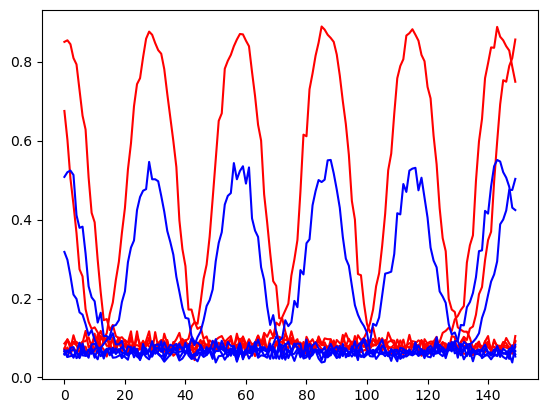

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


state_history1= np.load('reports/state_history_20250526_100226.npy') # FR
# state_history1 = np.load('reports/state_history_20250522_152023.npy') # newwww dynamics!!!
state_history2= np.load('reports/state_history_20250525_203443.npy') # CTR

# state_history2 = np.load('reports/state_history_20250525_194213.npy') # CTR
neural_array1 = state_history1
neural_array2 = state_history2
print(neural_array1.shape)
plt.plot(np.mean(neural_array1,axis = -1), color = 'red')
plt.plot(np.mean(neural_array2,axis = -1), color = 'blue')

# No SF

In [12]:
def compute_signal_vectors(response):
    """
    Compute Δμ for each ROI, SF, and pair of angles.
    response: (n_rois, n_angles, n_trials)
    Returns:
      Δμ: (n_rois, n_angles, n_angles)
    """
    # average over the chosen time window
    # average over trials
    mean_resp = np.nanmean(response, axis=-1)             # → (n_rois, n_angles)
    # subtract pairwise to get Δμ[:, i, j]
    dm = mean_resp[:, :, None] - mean_resp[:, None, :]     # → (n_rois, n_angles, n_angles)
    return dm  # shape (n_rois, n_angles, n_angles)

def compute_preferred_angles(response):
    """
    response: (n_rois, n_angles, n_trials)
    Returns:
        preferred_idx: (n_rois) giving for each neuron the preferred angle
    """
    # 1) average over trials and time
    rm = np.nanmean(response, axis=-1)             # → (n_rois, n_angles)
    n_angles = rm.shape[1]
    angles = np.arange(n_angles)
    preferred_idx = np.argmax(rm, axis=1)  # preferred angle for each neuron
    return preferred_idx  # shape (n_rois)


def compute_noise_metrics(response, signal_vectors, total_k=20):
    """
    response:       (n_rois, n_angles, n_trials)
    signal_vectors: (n_rois, n_angles, n_angles)

    Returns dict with:
      dot_prod       (n_angles, n_angles-1, total_k)
      top_evals      (n_angles, total_k)
      noise_corr     (n_angles,)
      mean_dist      (n_angles, n_angles-1)
      pc_coeff_pref  (n_rois, total_k)
    """
    resp = response  # (n_rois, n_angles, n_trials)
    n_rois, n_angles, n_trials = resp.shape

    dot_prod      = np.zeros((n_angles, n_angles-1, total_k))
    top_evals     = np.zeros((n_angles, total_k))
    noise_corr    = np.zeros((n_angles))
    mean_dist     = np.zeros((n_angles, n_angles-1))
    pc_coeff_pref = np.zeros((n_rois, total_k))

    for ia in range(n_angles):
        # 1) noise correlation across neurons
        dat = resp[:, ia, :]             # (n_rois, n_trials)
        C   = np.corrcoef(dat)           # (n_rois, n_rois)
        noise_corr[ia] = np.nanmean(C[~np.eye(n_rois, dtype=bool)])

        # 2) PCA on neuron‐by‐neuron covariance
        dat_T = dat.T                    # (n_trials, n_rois)
        S     = np.cov(dat_T, rowvar=False, ddof=1)  # (n_rois, n_rois)
        evals, evecs = np.linalg.eigh(S)
        order = np.argsort(evals)[::-1]

        for k in range(total_k):
            top_evals[ia, k] = evals[order[k]]
            pc_coeff_pref[:, k] = evecs[:, order[k]]

        # 3) nearest‐neighbor signal directions
        dists = np.linalg.norm(signal_vectors[:, ia, :], axis=0)  # length n_angles
        others = np.argsort(dists)
        others = others[others != ia][: n_angles-1]

        for j, ja in enumerate(others):
            sv  = signal_vectors[:, ia, ja]
            svu = sv / np.linalg.norm(sv)
            mean_dist[ia, j] = dists[ja]
            for k in range(total_k):
                pc = evecs[:, order[k]]
                dot_prod[ia, j, k] = abs(np.dot(svu, pc) / np.linalg.norm(pc))

    return {
        'dot_prod'     : dot_prod,
        'top_evals'    : top_evals,
        'noise_corr'   : noise_corr,
        'mean_dist'    : mean_dist,
        'pc_coeff_pref': pc_coeff_pref
    }


def analyze_animal(data, total_k=20):
    """
    Wrap everything for one animal.
    subject_key is the identifier you pass into your resort_preprocessing.
    """
    # 1) load & preprocess
    # data shape: (n_rois, n_angles, n_sfs, n_trials, n_time)

    # 2) preferred angles
    pref_idx = compute_preferred_angles(data)


    # 3) signal Δμ
    sig_vec = compute_signal_vectors(data)

    # 4) noise & PC metrics
    metrics = compute_noise_metrics(data, sig_vec, total_k)

    # 5) stash metadata
    metrics['n_rois']   = data.shape[0]
    metrics['preferred_idx'] = pref_idx

    return metrics


test_analysis = analyze_animal(neural_array1, total_k=20)

Text(0, 0.5, 'Dot Product (signal, kᵗʰ PC)')

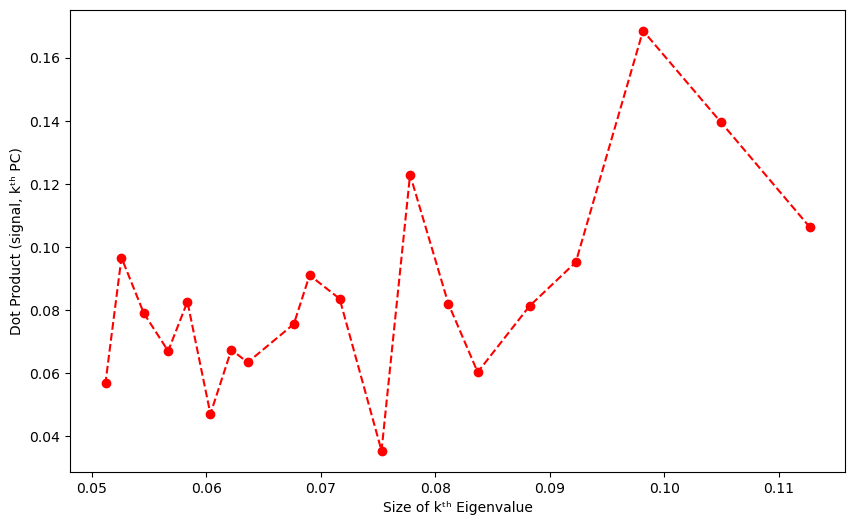

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def extract_plot_vectors(metrics_list, total_k):
    """
    From a single metric dict, build arrays:
      evals_plot : (1, total_k)
      dots_plot  : (1, total_k)
      dist_plot  : (1,)
    """
    # top eigenvalues: shape (n_angles, total_k)
    te = metrics_list['top_evals']
    evals_plot = np.nanmean(te, axis=0, keepdims=True)  # (1, total_k)

    # dot products: shape (n_angles, n_angles-1, total_k)
    dp = metrics_list['dot_prod']
    dp_avg = np.nanmean(dp, axis=0)  # (n_angles-1, total_k)
    dots_plot = dp_avg[0, :][None, :]  # (1, total_k)

    # mean distances: shape (n_angles, n_angles-1)
    md = metrics_list['mean_dist']
    md_avg = np.nanmean(md, axis=0)  # (n_angles-1,)
    dist_plot = md_avg[0][None]  # (1,)

    return evals_plot, dots_plot, dist_plot

# Extract for each group
total_k = test_analysis['top_evals'].shape[-1]
fr_evals_plot, fr_dots_plot, fr_dist_plot = extract_plot_vectors(test_analysis, total_k)

# Panel 1: eigenvalue size vs dot product, with across‐animal mean ± SEM
x_fr = np.nanmean(fr_evals_plot, axis=0)
y_fr = np.nanmean(fr_dots_plot, axis=0)
sem_fr = np.nanstd(fr_dots_plot, axis=0, ddof=1) / np.sqrt(fr_dots_plot.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(x_fr, y_fr, 'o--', color='red')
# plt.fill_between(x_fr, y_fr - sem_fr, y_fr + sem_fr, color='red',   alpha=0.2)
plt.xlabel('Size of kᵗʰ Eigenvalue')
plt.ylabel('Dot Product (signal, kᵗʰ PC)')

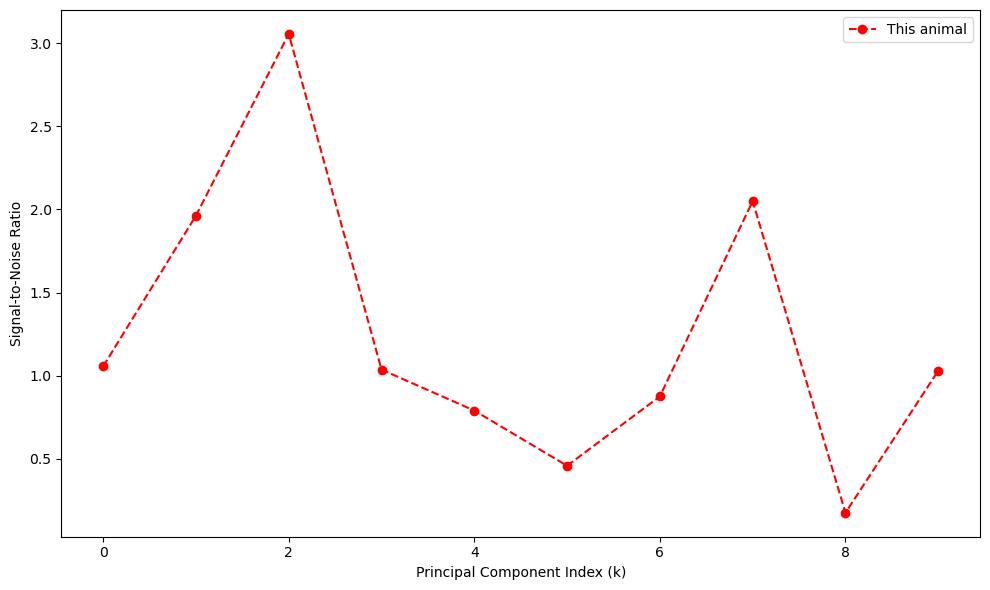

In [15]:
def extract_snr_beta_single(metrics, total_k):
    """
    From a single metric dict, compute arrays:
      snr:  shape (total_k,)
      beta: shape (total_k,)
    with
      snr = (mean_cos)^2 * (mean_dist)^2 / (mean_eval)
      beta = snr / (mean_eval)
    where means are over angles for the closest direction (j=0).
    """
    # top_evals: (n_angles, total_k)
    evals = metrics['top_evals']
    mean_eval = np.nanmean(evals, axis=0)  # (total_k,)

    # dot_prod: (n_angles, n_angles-1, total_k)
    cosines = metrics['dot_prod'][:, 0, :]        # (n_angles, total_k)
    mean_cos = np.nanmean(cosines, axis=0)        # (total_k,)

    # mean_dist: (n_angles, n_angles-1)
    dists = metrics['mean_dist'][:, 0]            # (n_angles,)
    mean_dist = np.nanmean(dists)                 # scalar

    snr = (mean_cos**2) * (mean_dist**2) / mean_eval
    beta = snr / mean_eval
    return snr, beta

snr, beta = extract_snr_beta_single(test_analysis, total_k)

x = np.arange(min(10, total_k))

plt.figure(figsize=(10,6))
plt.plot(x, snr[x], 'o--', color='red', label='This animal')
plt.xlabel('Principal Component Index (k)')
plt.ylabel('Signal‐to‐Noise Ratio')
plt.legend()
plt.tight_layout()


# Averaging over SF

In [18]:
def compute_signal_vectors(response):
    """
    Compute Δμ for each ROI, SF, and pair of angles.
    response: (n_rois, n_angles, n_sfs, n_trials)
    Returns:
      Δμ: (n_rois, n_angles, n_angles, n_sfs)
    """
    # average over trials
    mean_resp = np.nanmean(response, axis=-1)             # → (n_rois, n_angles, n_sfs)
    # subtract pairwise to get Δμ[:, i, j, sf]
    dm = mean_resp[:, :, np.newaxis, :] - mean_resp[:, np.newaxis, :, :]
    return dm  # shape (n_rois, n_angles, n_angles, n_sfs)


def compute_preferred_angles(response):
    """
    response: (n_rois, n_angles, n_sfs, n_trials)
    Returns:
        preferred_idx: (n_rois, n_sfs) giving for each neuron & SF the preferred angle
    """
    # 1) average over trials and time
    rm = np.nanmean(response, axis=-1)             # → (n_rois, n_angles, n_sfs)
    
    preferred_idx = np.argmax(rm, axis=1)  # preferred angle index for each neuron & SF
    return preferred_idx  # shape (n_rois, n_sfs)


def compute_noise_metrics(response, signal_vectors, total_k=20):
    """
    response:       (n_rois, n_angles, n_sfs, n_trials)
    signal_vectors: (n_rois, n_angles, n_angles, n_sfs)

    Returns dict with:
      dot_prod       (n_angles, n_angles-1, n_sfs, total_k)
      top_evals      (n_angles, n_sfs, total_k)
      noise_corr     (n_angles, n_sfs)
      mean_dist      (n_angles, n_angles-1, n_sfs)
      pc_coeff_pref  (n_rois, n_angles, n_sfs, total_k)
    """
    # average noise-response over time
    resp = response
    n_rois, n_angles, n_sfs, n_trials = resp.shape

    # outputs
    dot_prod      = np.zeros((n_angles, n_angles-1, n_sfs, total_k))
    top_evals     = np.zeros((n_angles, n_sfs, total_k))
    noise_corr    = np.zeros((n_angles, n_sfs))
    mean_dist     = np.zeros((n_angles, n_angles-1, n_sfs))
    pc_coeff_pref = np.zeros((n_rois,n_angles, n_sfs, total_k))

    for sf in range(n_sfs):
        for ia in range(n_angles):
            # 1) noise correlation across neurons
            dat = resp[:, ia, sf, :]             # (n_rois, n_trials)
            C   = np.corrcoef(dat)               # (n_rois, n_rois)
            noise_corr[ia, sf] = np.nanmean(C[~np.eye(n_rois, dtype=bool)])

            # 2) PCA on neuron‐by‐neuron covariance
            #    swap axes so trials×rois for rowvar=False
            dat_T = dat.T                         # (n_trials, n_rois)
            S     = np.cov(dat_T, rowvar=False, ddof=1)  # (n_rois, n_rois)
            evals, evecs = np.linalg.eigh(S)
            order = np.argsort(evals)[::-1]

            for k in range(total_k):
                top_evals[ia, sf, k] = evals[order[k]]
                pc_coeff_pref[:, ia,sf, k] = evecs[:,order[k]]

            # 3) nearest‐neighbor signal directions
            dists = np.linalg.norm(signal_vectors[:,ia,:, sf], axis=0)  # length n_angles
            others = np.argsort(dists)
            others = others[others != ia][: n_angles-1]

            for j, ja in enumerate(others):
                sv  = signal_vectors[:,ia,ja, sf]
                svu = sv / np.linalg.norm(sv)
                mean_dist[ia, j, sf] = dists[ja]
                for k in range(total_k):
                    pc = evecs[:, order[k]]
                    dot_prod[ia, j, sf, k] = abs(np.dot(svu, pc) / np.linalg.norm(pc))

    # pc_coeff_pref[np.isnan(pc_coeff_pref)] = 0
    return {
        'dot_prod'     : dot_prod,
        'top_evals'    : top_evals,
        'noise_corr'   : noise_corr,
        'mean_dist'    : mean_dist,
        'pc_coeff_pref': pc_coeff_pref
    }


def analyze_animal(data, total_k=20):
   
    pref_idx = compute_preferred_angles(data)
    sig_vec = compute_signal_vectors(data)

    metrics = compute_noise_metrics(data, sig_vec, total_k)
    metrics['preferred_idx'] = pref_idx
    return metrics
neural_array_sf1 = neural_array1.reshape(neural_array1.shape[0],neural_array1.shape[1],10,10)
fr_metrics  = (analyze_animal(data =neural_array_sf1,total_k=20))
neural_array_sf2 = neural_array2.reshape(neural_array2.shape[0],neural_array2.shape[1],3,10)
ctr_metrics = analyze_animal(data = neural_array_sf2,total_k=20)


Text(0, 0.5, 'Dot Product (signal, kᵗʰ PC)')

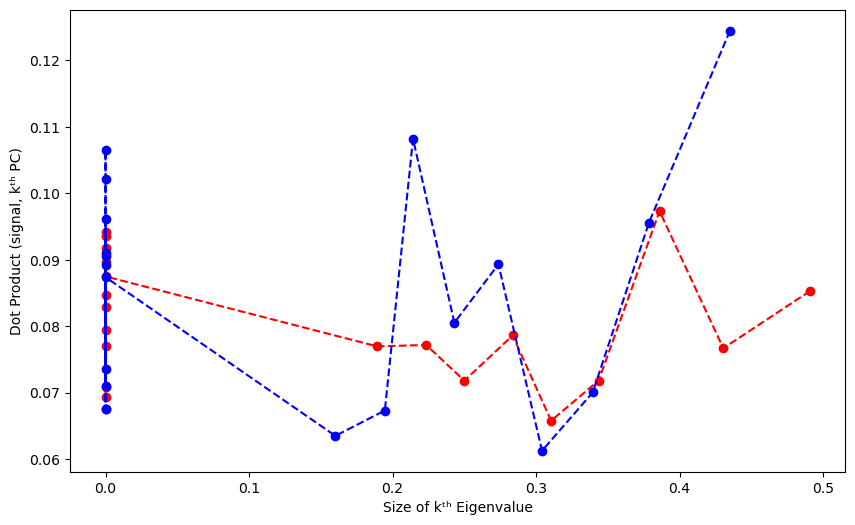

In [20]:
def extract_plot_vectors(metrics, total_k):
    """
    From a list of metric dicts, build arrays:
      evals_plot : ( total_k)
      dots_plot  : ( total_k)
      dist_plot  : ()
    following your original logic:
      - average top_evals over angles & SF, yielding (total_k,)
      - average dot_prod over angles & SF, yielding (n_angles-1, total_k), then take the closest j=0 row
      - average mean_dist over angles & SF, yielding (n_angles-1,), then take j=0
    """
    evals_plot = np.zeros((total_k))
    dots_plot  = np.zeros((total_k))
    dist_plot  =0
    snr_arr    = np.zeros((total_k))
    beta_arr   = np.zeros((total_k))

    # top eigenvalues: shape (n_angles, n_sfs, total_k)
    te = metrics['top_evals']
    evals_plot = np.nanmean(te, axis=(0,1))

    cosines = metrics['dot_prod'][:, 0, :, :]        # → (n_angles, n_sfs, total_k)
    mean_cos = np.nanmean(cosines, axis=(0,1)) # → (total_k,)
    dots_plot = mean_cos

    dists = metrics['mean_dist'][:, 0, :]            # → (n_angles, n_sfs)
    mean_dist = np.nanmean(dists, axis=(0,1))  # scalar
    dist_plot = mean_dist


    for k in range(total_k):
        snr_arr[k]  = (mean_cos[k]**2) * (mean_dist**2) / evals_plot[k]
        beta_arr[k] = (mean_cos[k])  / np.sqrt(evals_plot[k])

    return evals_plot, dots_plot, dist_plot, snr_arr, beta_arr

# Extract for each group
total_k = fr_metrics['top_evals'].shape[-1]
fr_evals_plot, fr_dots_plot, fr_dist_plot,snr_fr, beta_fr = extract_plot_vectors(fr_metrics, total_k)
ctr_evals_plot, ctr_dots_plot, ctr_dist_plot,snr_ctr, beta_ctr = extract_plot_vectors(ctr_metrics, total_k)
plt.figure(figsize=(10, 6))
plt.plot(fr_evals_plot, fr_dots_plot, 'o--', color = 'red')
plt.plot(ctr_evals_plot, ctr_dots_plot, 'o--', color='blue')

plt.xlabel('Size of kᵗʰ Eigenvalue')
plt.ylabel('Dot Product (signal, kᵗʰ PC)')

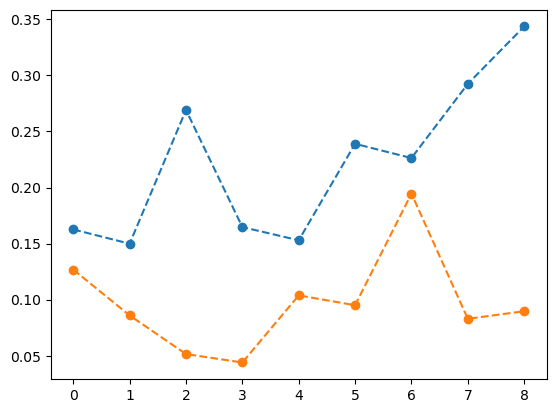

In [21]:

selected = np.arange(0, min(9, total_k))
plt.plot(selected,snr_fr[selected], 'o--')
plt.plot(selected,snr_ctr[selected], 'o--')


# Noise Correlations

(150, 6, 100)
(150, 6, 100)


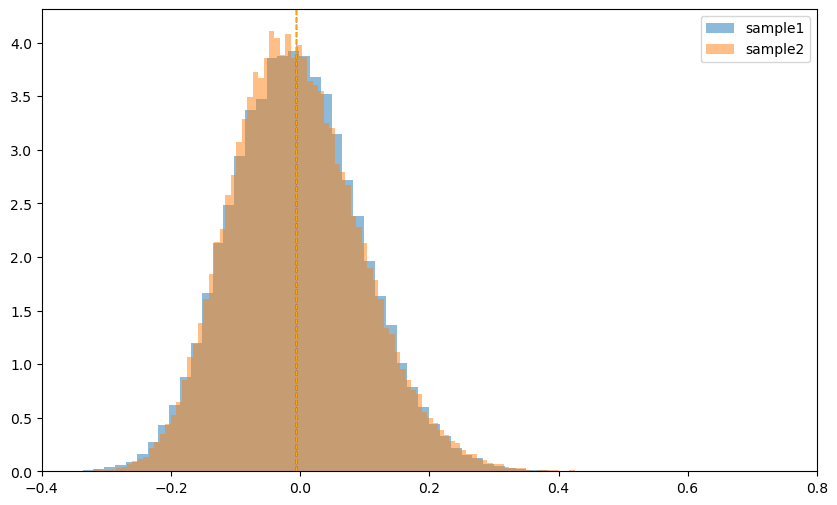

In [23]:
sample1 = np.load('reports/state_history_20250526_100226.npy')
sample2 = np.load('reports/state_history_20250525_203443.npy')


print(sample1.shape)
print(sample2.shape)

plt.figure(figsize=(10, 6))
def noise_corr_calc(testing):
    noise_corr = []
    for i in range(6):
        data = testing[:,i,:]
        corr = np.corrcoef(data)
        noise_corr.append((corr[~np.eye(data.shape[0], dtype=bool)]))
    return np.concatenate(noise_corr)


plt.hist(noise_corr_calc(sample1), bins=50, alpha=0.5, label='sample1', density=True)
plt.hist(noise_corr_calc(sample2), bins=100, alpha=0.5, label='sample2', density=True)
plt.axvline(np.nanmean(noise_corr_calc(sample1)), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.nanmean(noise_corr_calc(sample2)), color='orange', linestyle='dashed', linewidth=1)
plt.xlim(-0.4,0.8)
plt.legend()

In [1]:
from pathlib import Path
from typing import Dict, Tuple, List
import numpy as np
def run_id(ampar: float, rin: float, idir: float, trial: int) -> str:
    return f"g{ampar:.3f}_rin{rin:.3f}_idir{idir:.3f}_trial{trial:02d}"

def load_state_matrix(folder: Path) -> np.ndarray:
    history_file = folder / "state_history.npy"
    if not history_file.exists():
        raise FileNotFoundError(f"Missing state history file: {history_file}")
    states = np.load(history_file)          # generations × neurons
    if states.ndim != 2:
        raise ValueError(f"Expected 2-D array in {history_file}, got {states.shape}")
    return states.T                         # neurons × generations
def build_state_tensors() -> Dict[Tuple[float, float], np.ndarray]:
    tensors: Dict[Tuple[float, float], np.ndarray] = {}

    for ampar in AMPAR_VALUES:
        for rin in RIN_VALUES:
            idir_blocks = []
            for idir in IDIR_VALUES:
                trial_blocks = []
                for trial in TRIAL_INDICES:
                    folder = RUNS_DIR / run_id(ampar, rin, idir, trial)
                    matrix = load_state_matrix(folder)   # neurons × generations
                    trial_blocks.append(matrix)
                trial_cube = np.stack(trial_blocks, axis=2)      # neurons × generations × trials
                idir_blocks.append(trial_cube)
            tensors[(ampar, rin)] = np.stack(idir_blocks, axis=3)  # neurons × generations × trials × idir
    return tensors

In [2]:
from matplotlib import pyplot as plt
# --- Configure the runs you want to inspect ---------------------------------
RUNS_DIR = Path("runs_overnight")
AMPAR_VALUES: List[float] = [1, 0.63]
RIN_VALUES: List[float] = [1, 1.22]
IDIR_VALUES: List[float] = [0.2, 0.30, 0.40,0.5,0.6,0.7,0.8]
TRIAL_INDICES: List[int] = [0, 1, 2,3,4,5,6,7,8,9]  # trial00, trial01, trial02 folders

# ----------------------------------------------------------------------------

state_tensors = build_state_tensors()
state = state_tensors[0.63,1.22] # Neurons x Generations x idirs
# rolling average every 50 generations
window_size = 5
cumsum = np.cumsum(state, axis=1)
cumsum[:, window_size:] = cumsum[:, window_size:] - cumsum[:, :-window_size]
state = cumsum[:, window_size - 1:] / window_size

print(state.shape)
snr_per_mode = np.zeros((state.shape[2],state.shape[0],state.shape[3]))
evals_per_mode = np.zeros((state.shape[2],state.shape[0],state.shape[3]))

# plt.plot(np.mean(state[:,:,0],axis=1))
for angles in range(state.shape[3]):
    for trials in range(state.shape[2]):
        # do rolling average of state every 50 generations
        second_angle = (angles+1) % state.shape[3]
        delta_mu = np.mean(state[:,:,trials,angles],axis = 1) - np.mean(state[:,:,trials,second_angle], axis=1)
        covariance = np.cov(state[:,:,trials,angles])
        evals, evecs = np.linalg.eigh(covariance)
        # plt.hist(evals, bins=50)
        for k in range(evals.shape[0]):
            pc = evecs[:,k]
            signal_proj = np.dot(delta_mu, pc)#/np.linalg.norm(delta_mu)
            snr_per_mode[trials, k, angles] = (signal_proj**2) #/ evals[k]
            evals_per_mode[trials, k, angles] = evals[k]
            



(150, 4995, 10, 7)


In [3]:
state_tensors = build_state_tensors()
state = state_tensors[1,1] # Neurons x Generations x idirs
# rolling average every 50 generations
window_size = 5
cumsum = np.cumsum(state, axis=1)
cumsum[:, window_size:] = cumsum[:, window_size:] - cumsum[:, :-window_size]
state = cumsum[:, window_size - 1:] / window_size

print(state.shape)
snr_per_mode_normal = np.zeros((state.shape[2],state.shape[0],state.shape[3]))
evals_per_mode_normal = np.zeros((state.shape[2],state.shape[0],state.shape[3]))

# plt.plot(np.mean(state[:,:,0],axis=1))
for angles in range(state.shape[3]):
    for trials in range(state.shape[2]):
        # do rolling average of state every 50 generations
        second_angle = (angles+1) % state.shape[3]
        delta_mu = np.mean(state[:,:,trials,angles],axis = 1) - np.mean(state[:,:,trials,second_angle], axis=1)
        covariance = np.cov(state[:,:,trials,angles])
        evals, evecs = np.linalg.eigh(covariance)
        # plt.hist(evals, bins=50)
        for k in range(evals.shape[0]):
            pc = evecs[:,k]
            signal_proj = np.dot(delta_mu, pc)#/np.linalg.norm(delta_mu)
            snr_per_mode_normal[trials, k, angles] = (signal_proj**2) #/ evals[k]
            evals_per_mode_normal[trials, k, angles] = evals[k]
            


(150, 4995, 10, 7)


In [6]:
#remove top two largest eigenmodes and angle 6
pos_largest =  []#np.argsort(np.mean(evals_per_mode, axis=(0,2)))[-3:]
evals_per_mode_del = np.delete(evals_per_mode.copy(), pos_largest, axis=1)
snr_per_mode_del = np.delete(snr_per_mode.copy(), pos_largest, axis=1)
# evals_per_mode = np.delete(evals_per_mode, 6, axis=2)
# snr_per_mode = np.delete(snr_per_mode, 6, axis=2)
# bin/window parameters
step = 0.002
x = np.mean(evals_per_mode_del, axis=(0,2))
y = np.mean(snr_per_mode_del, axis=(0,2))

xmin, xmax = x.min(), x.max()
bins = np.arange(xmin, xmax + step, step)

binned_x = []
binned_y = []
for left in bins:
    right = left + step
    mask = (x >= left) & (x < right)
    if not np.any(mask):
        continue
    binned_x.append(x[mask].mean())
    binned_y.append(y[mask].mean())

binned_x = np.array(binned_x)
binned_y = np.array(binned_y)

#remove top two largest eigenmodes and angle 6
pos_largest = []#np.argsort(np.mean(evals_per_mode_normal, axis=(0,2)))[-3:]
evals_per_mode_normal_del = np.delete(evals_per_mode_normal.copy(), pos_largest, axis=1)
snr_per_mode_normal_del = np.delete(snr_per_mode_normal.copy(), pos_largest, axis=1)
# evals_per_mode = np.delete(evals_per_mode, 6, axis=2)
# snr_per_mode = np.delete(snr_per_mode, 6, axis=2)

# bin/window parameters
step = 0.002
x = np.mean(evals_per_mode_normal_del, axis=(0,2))
y = np.mean(snr_per_mode_normal_del, axis=(0,2))

xmin, xmax = x.min(), x.max()
bins = np.arange(xmin, xmax + step, step)

binned_x_normal = []
binned_y_normal = []
for left in bins:
    right = left + step
    mask = (x >= left) & (x < right)
    if not np.any(mask):
        continue
    binned_x_normal.append(x[mask].mean())
    binned_y_normal.append(y[mask].mean())

binned_x_normal = np.array(binned_x_normal)
binned_y_normal = np.array(binned_y_normal)


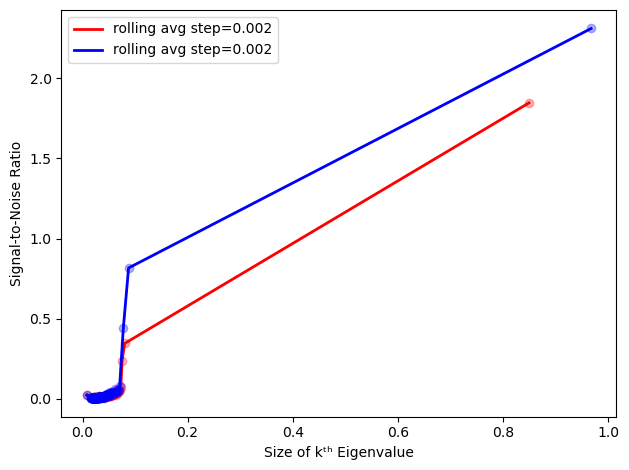

In [7]:

plt.plot(np.mean(evals_per_mode_del, axis=(0,2)), np.mean(snr_per_mode_del, axis=(0,2)), 'o--', color = 'red', alpha = 0.3)
plt.plot(binned_x, binned_y, '-', color='red', linewidth=2, label=f'rolling avg step={step}')

plt.plot(np.mean(evals_per_mode_normal_del, axis=(0,2)), np.mean(snr_per_mode_normal_del, axis=(0,2)), 'o--', color = 'blue', alpha =0.3)
plt.plot(binned_x_normal, binned_y_normal, '-', color='blue', linewidth=2, label=f'rolling avg step={step}')
plt.legend()
plt.xlabel('Size of kᵗʰ Eigenvalue')
# plt.ylabel('Cos^2')
plt.ylabel('Signal‐to‐Noise Ratio')

plt.tight_layout()



# for i in range(state.shape[3]-1):
    # plt.plot(np.mean(evals_per_mode[:,:,i], axis=(0)), np.mean(snr_per_mode[:,:,i], axis=(0)), 'o--', label=f'Angle {i}')

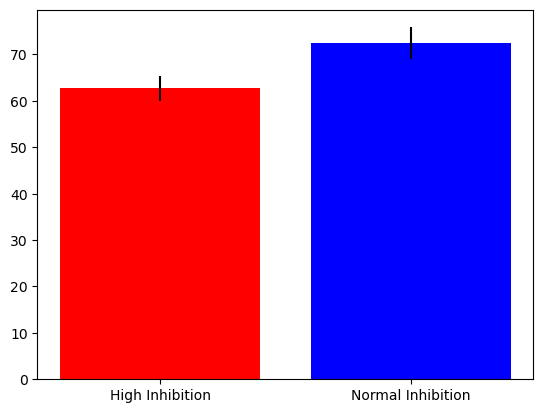

In [8]:
snr_sum = np.sum(snr_per_mode_del/evals_per_mode_del, axis=1)
snr_mean = np.mean(snr_sum, axis=(0,1))
snr_mean_error = np.std(snr_sum, axis=(0,1), ddof=1) / np.sqrt(snr_sum.shape[0]*snr_sum.shape[1])

snr_sum_normal = np.sum(snr_per_mode_normal_del/evals_per_mode_normal_del, axis=1)
snr_mean_normal = np.mean(snr_sum_normal, axis=(0,1))
snr_mean_error_normal = np.std(snr_sum_normal, axis=(0,1), ddof=1) / np.sqrt(snr_sum_normal.shape[0]*snr_sum_normal.shape[1])
plt.bar([0,1], [snr_mean, snr_mean_normal], yerr=[snr_mean_error, snr_mean_error_normal], color=['red','blue'], tick_label=['High Inhibition','Normal Inhibition'])

fourtyquartile = np.percentile(snr_sum, 25)
sixtyquartile = np.percentile(snr_sum, 90)
# plt.ylim(fourtyquartile , sixtyquartile+30)

In [34]:
from matplotlib import pyplot as plt
# --- Configure the runs you want to inspect ---------------------------------
RUNS_DIR = Path("runs_novaryx_13_nov")
AMPAR_VALUES: List[float] = [0.63]
RIN_VALUES: List[float] = [1.22]
IDIR_VALUES: List[float] = [0.5,0.6]
TRIAL_INDICES: List[int] = [0, 1, 2,3,4,5,6,7,8,9]  # trial00, trial01, trial02 folders

# ----------------------------------------------------------------------------

state_tensors = build_state_tensors()
state = state_tensors[0.63,1.22] # Neurons x Generations x idirs
# rolling average every 50 generations
window_size = 10
cumsum = np.cumsum(state, axis=1)
cumsum[:, window_size:] = cumsum[:, window_size:] - cumsum[:, :-window_size]
state = cumsum[:, window_size - 1:] / window_size

print(state.shape)
snr_per_mode = np.zeros((state.shape[2],state.shape[0],state.shape[3]))
evals_per_mode = np.zeros((state.shape[2],state.shape[0],state.shape[3]))

# plt.plot(np.mean(state[:,:,0],axis=1))
for angles in range(state.shape[3]):
    for trials in range(state.shape[2]):
        # do rolling average of state every 50 generations
        second_angle = (angles+1) % state.shape[3]
        delta_mu = np.mean(state[:,:,trials,angles],axis = 1) - np.mean(state[:,:,trials,second_angle], axis=1)
        covariance = np.cov(state[:,:,trials,angles])
        evals, evecs = np.linalg.eigh(covariance)
        # plt.hist(evals, bins=50)
        for k in range(evals.shape[0]):
            pc = evecs[:,k]
            signal_proj = np.dot(delta_mu, pc)#/np.linalg.norm(delta_mu)
            snr_per_mode[trials, k, angles] = (signal_proj**2) #/ evals[k]
            evals_per_mode[trials, k, angles] = evals[k]
            
# --- Configure the runs you want to inspect ---------------------------------
RUNS_DIR = Path("runs_novaryx_13_nov")
AMPAR_VALUES: List[float] = [1]
RIN_VALUES: List[float] = [1]
IDIR_VALUES: List[float] = [0.5,0.6]
TRIAL_INDICES: List[int] = [0, 1, 2,3,4,5,6,7,8,9]  # trial00, trial01, trial02 folders
state_tensors = build_state_tensors()
state = state_tensors[1,1] # Neurons x Generations x idirs
# rolling average every 50 generations
window_size = 10
cumsum = np.cumsum(state, axis=1)
cumsum[:, window_size:] = cumsum[:, window_size:] - cumsum[:, :-window_size]
state = cumsum[:, window_size - 1:] / window_size

print(state.shape)
snr_per_mode_normal = np.zeros((state.shape[2],state.shape[0],state.shape[3]))
evals_per_mode_normal = np.zeros((state.shape[2],state.shape[0],state.shape[3]))

# plt.plot(np.mean(state[:,:,0],axis=1))
for angles in range(state.shape[3]):
    for trials in range(state.shape[2]):
        # do rolling average of state every 50 generations
        second_angle = (angles+1) % state.shape[3]
        delta_mu = np.mean(state[:,:,trials,angles],axis = 1) - np.mean(state[:,:,trials,second_angle], axis=1)
        covariance = np.cov(state[:,:,trials,angles])
        evals, evecs = np.linalg.eigh(covariance)
        # plt.hist(evals, bins=50)
        for k in range(evals.shape[0]):
            pc = evecs[:,k]
            signal_proj = np.dot(delta_mu, pc)#/np.linalg.norm(delta_mu)
            snr_per_mode_normal[trials, k, angles] = (signal_proj**2) #/ evals[k]
            evals_per_mode_normal[trials, k, angles] = evals[k]
            
#remove top two largest eigenmodes and angle 6
pos_largest =  []#np.argsort(np.mean(evals_per_mode, axis=(0,2)))[-3:]
evals_per_mode_del = np.delete(evals_per_mode.copy(), pos_largest, axis=1)
snr_per_mode_del = np.delete(snr_per_mode.copy(), pos_largest, axis=1)
# evals_per_mode = np.delete(evals_per_mode, 6, axis=2)
# snr_per_mode = np.delete(snr_per_mode, 6, axis=2)
# bin/window parameters
step = 0.005
x = np.mean(evals_per_mode_del, axis=(0,2))
y = np.mean(snr_per_mode_del, axis=(0,2))

xmin, xmax = x.min(), x.max()
bins = np.arange(xmin, xmax + step, step)

binned_x = []
binned_y = []
for left in bins:
    right = left + step
    mask = (x >= left) & (x < right)
    if not np.any(mask):
        continue
    binned_x.append(x[mask].mean())
    binned_y.append(y[mask].mean())

binned_x = np.array(binned_x)
binned_y = np.array(binned_y)

#remove top two largest eigenmodes and angle 6
pos_largest = []#np.argsort(np.mean(evals_per_mode_normal, axis=(0,2)))[-3:]
evals_per_mode_normal_del = np.delete(evals_per_mode_normal.copy(), pos_largest, axis=1)
snr_per_mode_normal_del = np.delete(snr_per_mode_normal.copy(), pos_largest, axis=1)
# evals_per_mode = np.delete(evals_per_mode, 6, axis=2)
# snr_per_mode = np.delete(snr_per_mode, 6, axis=2)

# bin/window parameters
step = 0.005
x = np.mean(evals_per_mode_normal_del, axis=(0,2))
y = np.mean(snr_per_mode_normal_del, axis=(0,2))

xmin, xmax = x.min(), x.max()
bins = np.arange(xmin, xmax + step, step)

binned_x_normal = []
binned_y_normal = []
for left in bins:
    right = left + step
    mask = (x >= left) & (x < right)
    if not np.any(mask):
        continue
    binned_x_normal.append(x[mask].mean())
    binned_y_normal.append(y[mask].mean())

binned_x_normal = np.array(binned_x_normal)
binned_y_normal = np.array(binned_y_normal)



(150, 4990, 10, 2)
(150, 4990, 10, 2)


(0.0, 0.08)

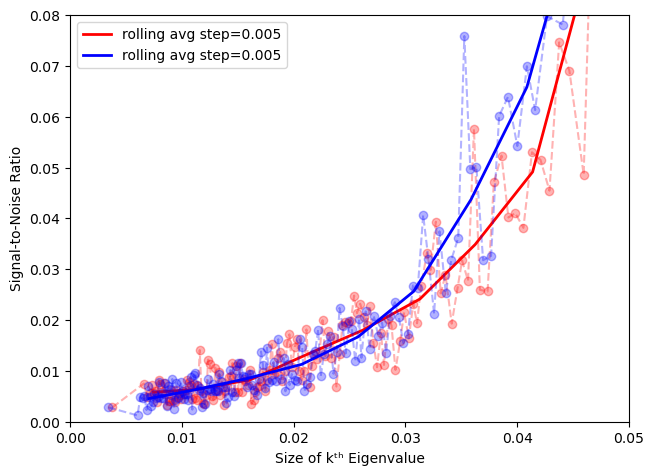

In [42]:

plt.plot(np.mean(evals_per_mode_del, axis=(0,2)), np.mean(snr_per_mode_del, axis=(0,2)), 'o--', color = 'red', alpha = 0.3)
plt.plot(binned_x, binned_y, '-', color='red', linewidth=2, label=f'rolling avg step={step}')

plt.plot(np.mean(evals_per_mode_normal_del, axis=(0,2)), np.mean(snr_per_mode_normal_del, axis=(0,2)), 'o--', color = 'blue', alpha =0.3)
plt.plot(binned_x_normal, binned_y_normal, '-', color='blue', linewidth=2, label=f'rolling avg step={step}')
plt.legend()
plt.xlabel('Size of kᵗʰ Eigenvalue')
# plt.ylabel('Cos^2')
plt.ylabel('Signal‐to‐Noise Ratio')

plt.tight_layout()


plt.xlim(0,0.05)
plt.ylim(0,0.08)
# for i in range(state.shape[3]-1):
    # plt.plot(np.mean(evals_per_mode[:,:,i], axis=(0)), np.mean(snr_per_mode[:,:,i], axis=(0)), 'o--', label=f'Angle {i}')

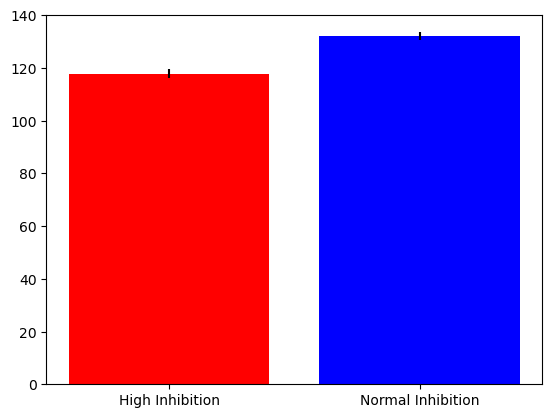

In [43]:
snr_sum = np.sum(snr_per_mode_del/evals_per_mode_del, axis=1)
snr_mean = np.mean(snr_sum, axis=(0,1))
snr_mean_error = np.std(snr_sum, axis=(0,1), ddof=1) / np.sqrt(snr_sum.shape[0]*snr_sum.shape[1])

snr_sum_normal = np.sum(snr_per_mode_normal_del/evals_per_mode_normal_del, axis=1)
snr_mean_normal = np.mean(snr_sum_normal, axis=(0,1))
snr_mean_error_normal = np.std(snr_sum_normal, axis=(0,1), ddof=1) / np.sqrt(snr_sum_normal.shape[0]*snr_sum_normal.shape[1])
plt.bar([0,1], [snr_mean, snr_mean_normal], yerr=[snr_mean_error, snr_mean_error_normal], color=['red','blue'], tick_label=['High Inhibition','Normal Inhibition'])

fourtyquartile = np.percentile(snr_sum, 25)
sixtyquartile = np.percentile(snr_sum, 90)
# plt.ylim(fourtyquartile , sixtyquartile+30)